# Plant Seedlings Classification
# AI-0029

In my opinion, the prime challenge in this project was the quality of the data. The quantity of the labeled data is also not adequate if we account in the quality of the data.
So, the logical steps toward the solution might be like this:
1. Building a CNN from scratch.
2. Transfer Learning: Using pretrained powerfull models to make everything right
3. Preprocessing: Editting the train,test data to make the features more visible

In this project, I started from the 1 and went down to the last option.

# Importing the dependencies

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, Lambda
from keras.optimizers import RMSprop, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import applications


Using TensorFlow backend.


Using the ImageDataGenerator with flow from directory option. The parameters of the Generator are choosed logically.

In [ ]:
train_datagen = ImageDataGenerator(
            rescale=1./255,
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
            zoom_range = 0.2, # Randomly zoom image 
            width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=True)  # randomly flip images

test_datagen = ImageDataGenerator(rescale=1./255)

train_set = train_datagen.flow_from_directory(
        'dataset/train',
        target_size=(150, 150),
        class_mode='categorical')

test_set = test_datagen.flow_from_directory(
        'dataset/test',
        target_size=(150, 150),
        class_mode = None)


# 1. Building the model from scratch

In [ ]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (150,150,3)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(3,3)))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(512, activation = "relu"))
model.add(Dropout(0.4))
model.add(Dense(512, activation = "relu"))
model.add(Dropout(0.4))
model.add(Dense(12, activation = "softmax"))

Compiling the model with an optimizer. Adam is used without any special reason.

In [ ]:
model.compile(optimizer = 'adam' , loss = "categorical_crossentropy", metrics=["accuracy"])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

Fitting the data to the model

In [ ]:
print('Started fitting...')
batch_size = 32
epoch = 40
history = model.fit_generator(
        train_set,
        epochs=epoch,
        steps_per_epoch= 4750/batch_size)
print('Finished fitting...')

Prediction

In [ ]:
print('Started Prediction...')
ansr = model.predict_generator(
        test_set, steps=794/batch_size, verbose=1)
print('Finished Prediction....')

Exporting the result and training graph

In [ ]:
ID = test_set.filenames
ansr = ansr.argmax(axis=-1)
ansr = ansr.tolist()
ID_PD = pd.DataFrame(ID)
ansr_PD = pd.DataFrame(ansr)

# Result with Category Number
result = pd.DataFrame({'file':ID,'species':ansr})
result.to_csv("Transfer_number.csv",index=False)

# Invert dictionary
label_dict = train_set.class_indices

label_name = {v:k for k, v in label_dict.items()}

for x in range(len(ansr)):
    ansr[x]= label_name[ansr[x]]

# Result with label
result = pd.DataFrame({'file':ID,'species':ansr})
result.to_csv("Transfer_label.csv",index=False)


print('Done Exporting The Result')

fig = plt.figure()
plt.plot( history.history['acc'], color='blue', linewidth=2)
fig.suptitle('Accuracy in the Training Period', fontsize=20)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Accuracy', fontsize=16)
fig.savefig('Training.jpg')

print('Saved Graph')

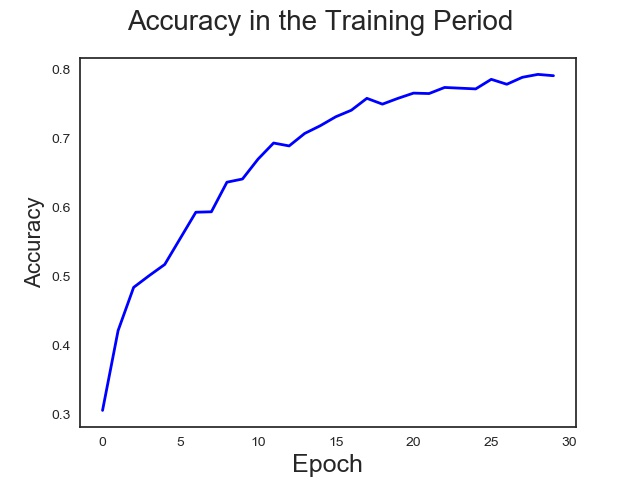

# Kaggle Score for this model

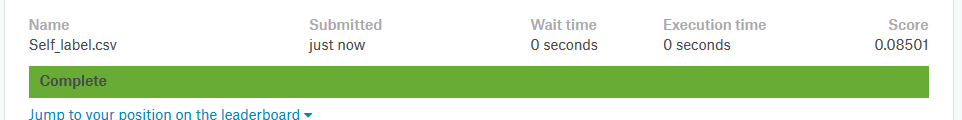

This might be the lowest score anyone achieved!
But one thing is noticeable- The difference between the training and testing. The model picked up some wrong features and overfitted. 
Let's try out the next road.

# 2. Model using Transfer Learning
Here, I used Xception pretrained model for transfer learning. One thing should be noted here. When I was working on this project, whenever I tried to download the model weights from the keras website, it shutted the connection aftersometimes. So I downloaded the weight file seperately and loaded it into the bare structure.
The top portion is chosen arbitrarily 

# 2.1. Building the Xception model

In [ ]:
model = applications.xception.Xception(include_top=True, weights=None)
print('Loaded Architecture')
model.load_weights('Xception_weight.h5')
print('Loaded Weights')
model.compile(optimizer = 'adam' , loss = "categorical_crossentropy", metrics=["accuracy"])
model.save('Xception.h5')
print(model.summary())

# 2.2. Building the Hybrid model for our job

In [ ]:
#Base part. Import pre-trained model
base_part= load_model('Xception.h5')

#remove the last layer
base_part.layers.pop()


model = Sequential()
# Add the base part
model.add(base_part)
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.4))
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.4))
model.add(Dense(12, activation = "softmax"))

del base_part

#Freeze the base part
model.layers[0].trainable=False

print(model.summary())

Rest of the code is same as before

In [ ]:
model.compile(optimizer = 'adam' , loss = "categorical_crossentropy", metrics=["accuracy"])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
print('Started fitting...')
batch_size = 32
epoch = 40
history = model.fit_generator(
        train_set,
        epochs=epoch,
        steps_per_epoch= 4750/batch_size)
print('Finished fitting...')

print('Started Prediction...')
ansr = model.predict_generator(
        test_set, steps=794/batch_size, verbose=1)
print('Finished Prediction....')

ID = test_set.filenames
ansr = ansr.argmax(axis=-1)
ansr = ansr.tolist()
ID_PD = pd.DataFrame(ID)
ansr_PD = pd.DataFrame(ansr)

result = pd.DataFrame({'file':ID,'species':ansr})
result.to_csv("Transfer_number.csv",index=False)

label_dict = train_set.class_indices

label_name = {v:k for k, v in label_dict.items()}

for x in range(len(ansr)):
    ansr[x]= label_name[ansr[x]]

result = pd.DataFrame({'file':ID,'species':ansr})
result.to_csv("Transfer_label.csv",index=False)


print('Done Exporting The Result')

fig = plt.figure()
plt.plot( history.history['acc'], color='blue', linewidth=2)
fig.suptitle('Accuracy in the Training Period', fontsize=20)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Accuracy', fontsize=16)
fig.savefig('Training.jpg')

print('Saved Graph')

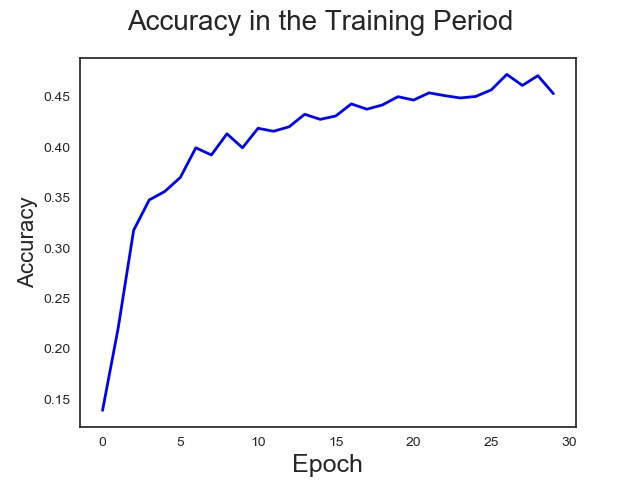

# Kaggle Score for this model

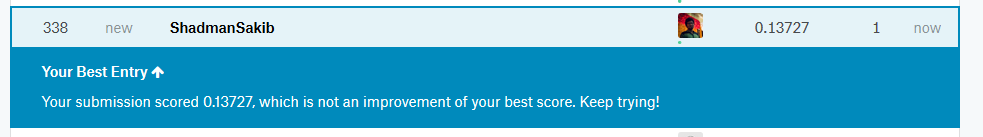

Which is in fact a great improvement considering the last one. But still- it's very low. And If we pay attention- the overfitting is still there. Neither of the models could find out the actual features. But they found something for sure. That's why the train accuracy is high. That means, there is something wrong about the data.. 

# Examining the data
So After this point, I went through the images and found something interesting (read: "devastating")

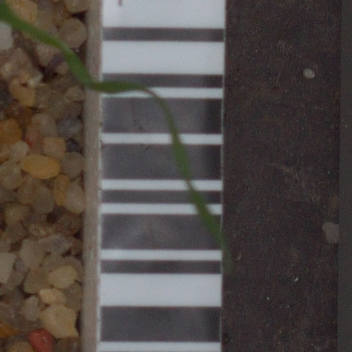

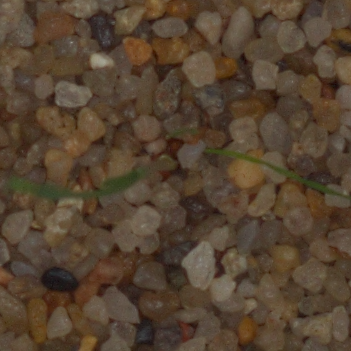

These are some of the train images. even I, a human with NATURAL Neural Network, can't find the plants in many of the images. they are hard to find. I found three importand properties of the data-
1. Some of the plants are very tiny and unrecognizable.
2. Image quality is very bad
3. There are some colorful pebbles in every images. The classifier might have found pattern in those pebbles.

So, we need to enhance the images first.

# 3. Image preprocessing: Enhancement of the actual features.

Now we need a way to somehow 'Mark' or 'Enhance' the actual plant in the images. After examining some of the images, I found that there are no other 'Green Objects' in the images other than the plants. So, we can simple filter the green color in every image before processing it. And to do this, we need two new libraries.  

In [ ]:
import cv2
import glob

As an initial step, I filtered the whole images and made a binary one based on the color. For doing this, we will loose the texture and some other visual properties of the plants, but will get the dimensions right. That should help. If everything goes right, then we can add something more.


In [ ]:
print('Editting Test Data...')

for filename in glob.glob('dataset/test/test/*.png'): 
    pic = cv2.imread(filename)
    pic = cv2.cvtColor(pic, cv2.COLOR_BGR2HSV)
    pic = cv2.inRange(pic, (30,50,50), (90,255,255))
    cv2.imwrite(filename, pic)

print('Editting Train Data...')

for filename in glob.glob('dataset/train/**/*.png'): 
    pic = cv2.imread(filename)
    pic = cv2.cvtColor(pic, cv2.COLOR_BGR2HSV)
    pic = cv2.inRange(pic, (30,50,50), (90,255,255))
    cv2.imwrite(filename, pic)

print('Finished Editting Data...')

Sample: See the same image below before and after the 'inRange' binary conversion

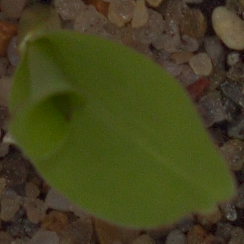

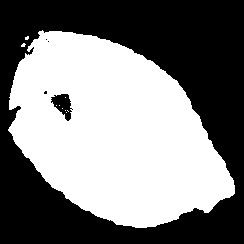

The rest of the code is just like the previous one. Just one thing is changed. That is the base model. I managed the official weights of the VGG19 model from another computer and copy-pasted in the /~/.keras/ directory. It works now. SO, I used VGG19 here.

In [ ]:
train_datagen = ImageDataGenerator(
            rescale=1./255,
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
            zoom_range = 0.2, # Randomly zoom image 
            width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=True)  # randomly flip images

test_datagen = ImageDataGenerator(rescale=1./255)

train_set = train_datagen.flow_from_directory(
        'dataset/train',
        target_size=(150, 150),
        class_mode='categorical')

test_set = test_datagen.flow_from_directory(
        'dataset/test',
        target_size=(150, 150),
        class_mode = None)


'''
Model Building Section Started
'''


#Base part. Import pre-trained model
base_part = applications.vgg19.VGG19(include_top=False, weights='imagenet',input_shape=(150,150,3))

print(base_part.summary())

model = Sequential()

# Add the base part
model.add(base_part)
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.4))
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.4))
model.add(Dense(12, activation = "softmax"))

del base_part

#Freeze the base part
model.layers[0].trainable=False

print(model.summary())


'''
Model Building Ended
'''

optimizer = Adam()
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)


print('Started fitting...')
batch_size = 32
epoch = 40
history = model.fit_generator(
        train_set,
        epochs=epoch,
        steps_per_epoch= 4750/batch_size)
print('Finished fitting...')

print('Started Prediction...')
ansr = model.predict_generator(
        test_set, steps=794/batch_size, verbose=1)
print('Finished Prediction....')


ID = test_set.filenames
ansr = ansr.argmax(axis=-1)
ansr = ansr.tolist()
ID_PD = pd.DataFrame(ID)
ansr_PD = pd.DataFrame(ansr)

result = pd.DataFrame({'file':ID,'species':ansr})
result.to_csv("Transfer_number.csv",index=False)

label_dict = train_set.class_indices

label_name = {v:k for k, v in label_dict.items()}

for x in range(len(ansr)):
    ansr[x]= label_name[ansr[x]]

result = pd.DataFrame({'file':ID,'species':ansr})
result.to_csv("Transfer_label.csv",index=False)


print('Done Exporting The Result')

fig = plt.figure()
plt.plot( history.history['acc'], color='blue', linewidth=2)
fig.suptitle('Accuracy in the Training Period', fontsize=20)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Accuracy', fontsize=16)
fig.savefig('Training.jpg')

print('Saved Graph')

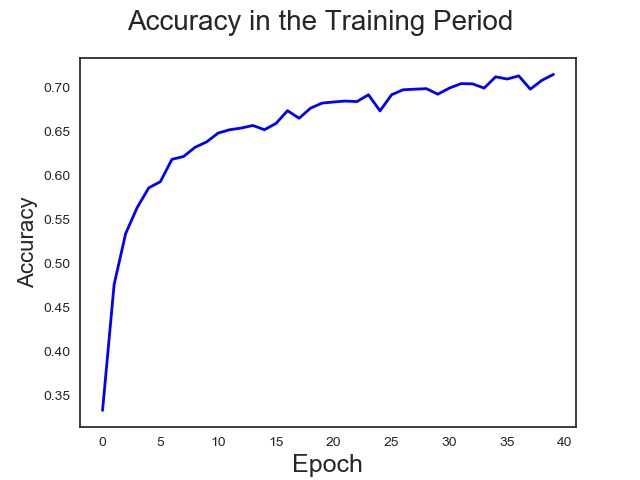

# Kaggle Score for this model

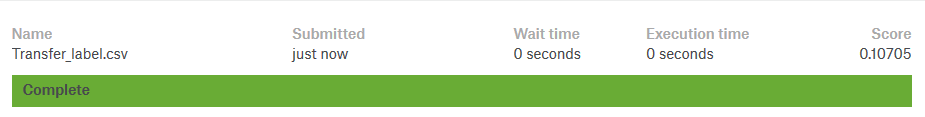

This is also surprisingly low. One thing is for sure- the data was in better condition than the previous times. So, we can say that-
1. Xception was a better choice than VGG19
2. We should keep the color but filter the rest.

So, considering all these, I designed the last model.


# Last Model

The only new part here is the image filtering part. we used the image returned by the inRange function and used it as a mask. Then after a logical and operation, between the original and the new one, we got a colorful image subtracted image of the plant. 

In [ ]:
print('Editting Test Data...')

for filename in glob.glob('dataset/test/test/*.png'): 
    pic = cv2.imread(filename)
    pic = cv2.cvtColor(pic, cv2.COLOR_BGR2HSV)
    msk = cv2.inRange(pic, (30,50,50), (90,255,255))
    pic = cv2.bitwise_and(pic,pic, mask=msk)
    cv2.imwrite(filename, pic)

print('Editting Train Data...')

for filename in glob.glob('dataset/train/**/*.png'): 
    pic = cv2.imread(filename)
    pic = cv2.cvtColor(pic, cv2.COLOR_BGR2HSV)
    msk = cv2.inRange(pic, (30,50,50), (90,255,255))
    pic = cv2.bitwise_and(pic,pic, mask=msk)
    cv2.imwrite(filename, pic)

print('Finished Editting Data...')

This is shown in the next images. They are the same image. The second one is obtained by filtering the first one. 

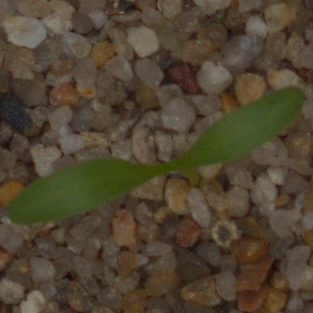

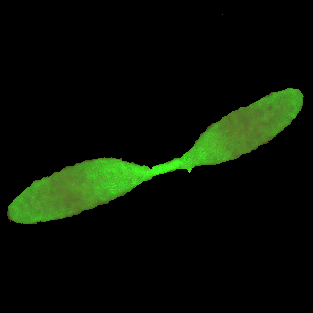

The later portion of the script is same as before...

In [ ]:
train_datagen = ImageDataGenerator(
            rescale=1./255,
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
            zoom_range = 0.2, # Randomly zoom image 
            width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=True)  # randomly flip images

test_datagen = ImageDataGenerator(rescale=1./255)

train_set = train_datagen.flow_from_directory(
        'dataset/train',
        target_size=(150, 150),
        class_mode='categorical')

test_set = test_datagen.flow_from_directory(
        'dataset/test',
        target_size=(150, 150),
        class_mode = None)



'''
Model Building Section Started
'''


#Base part. Import pre-trained model
base_part= load_model('Xception.h5')
print(base_part.summary())


model = Sequential()
# Add the base part
model.add(base_part)
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.4))
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.4))
model.add(Dense(12, activation = "softmax"))

del base_part

#Freeze the base part
model.layers[0].trainable=False

print(model.summary())


'''
Model Building Ended
'''

optimizer = Adam()
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)


print('Started fitting...')
batch_size = 32
epoch = 40
history = model.fit_generator(
        train_set,
        epochs=epoch,
        steps_per_epoch= 4750/batch_size)
print('Finished fitting...')


print('Started Prediction...')
ansr = model.predict_generator(
        test_set, steps=794/batch_size, verbose=1)
print('Finished Prediction....')


ID = test_set.filenames
ansr = ansr.argmax(axis=-1)
ansr = ansr.tolist()
ID_PD = pd.DataFrame(ID)
ansr_PD = pd.DataFrame(ansr)

result = pd.DataFrame({'file':ID,'species':ansr})
result.to_csv("Transfer_number.csv",index=False)

label_dict = train_set.class_indices

label_name = {v:k for k, v in label_dict.items()}

for x in range(len(ansr)):
    ansr[x]= label_name[ansr[x]]

result = pd.DataFrame({'file':ID,'species':ansr})
result.to_csv("Transfer_label.csv",index=False)


print('Done Exporting The Result')

fig = plt.figure()
plt.plot( history.history['acc'], color='blue', linewidth=2)
fig.suptitle('Accuracy in the Training Period', fontsize=20)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Accuracy', fontsize=16)
fig.savefig('Training.jpg')

print('Saved Graph')

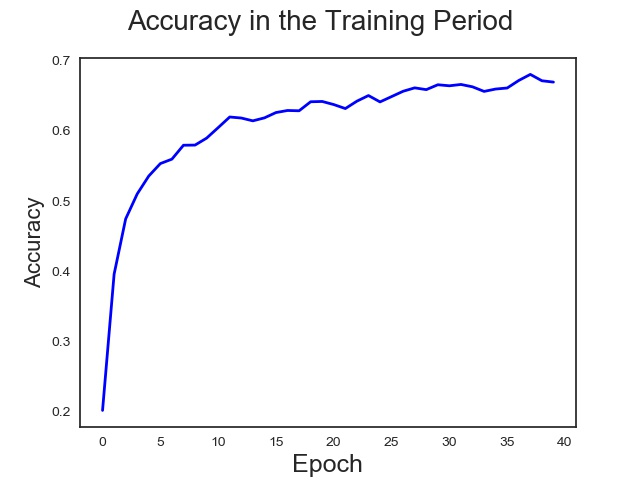

I was very hopeful about this model. But somehow the kaggle accuracy was very poor, which I dont know why...

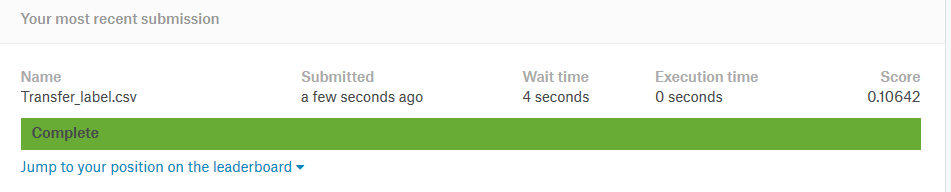